This Example teaches the user to use the `main.evolve()` function.  Given a model of decaying or annihilating DM, `main.evolve()` will compute:

   (1) The free electron fraction as a function of redshift, $x_e(z) = n_e(z)/n_{HI}(z)$
    
   (2) The baryon temperature as a function of redshift, $T_m(z)$
    
   (3) The high energy photon spectra, and low energy photon/electron spectra as a function of z
    
   (4) The energy deposition fractions, $f_c(z)$

We will walk the user through an example of DM that decays or (s-wave) annihilates into photons to calculate the effect of "backreaction" on the energy deposition fractions, $f_c(z)$.

# Full Transfer Functions

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

# np.set_printoptions(threshold=np.nan)

In the standard temperature/ionization history calculation,
one solves the TLA assuming no DM energy injection. 

$$ \dot{T}_m = -2 H T_m + \Gamma_C \left(T_{CMB} - T_m \right), $$
$$ \dot{x}_e = - \mathcal{C} \left[ n_H x_e^2 \alpha_B - 4 (1 - x_e) \beta_B e^{-E_{21}/T_{CMB}} \right]. $$

The solution to these coupled ODEs subject to the initial conditions 
$$\left. x_e \right|_{z=3000} = 1$$ $$\left( T_m = T_{CMB} \right)_{z=3000}$$ 
provides the standard $x_e$ and $T_m$ histories, which are loaded below.

In [3]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

To include the effect of DM energy injection, one adds to the TLA the following terms

$$ \dot{T}^\chi_m = \frac{2 f_\text{heat}(z)}{3 (1 + f_\text{He} + x_e(z)) n_H(z)} \left(\frac{dE}{dV \, dt} \right)^\text{inj}, $$
$$ \dot{x}^\chi_e = \left[\frac{f_\text{ion}(z)}{\mathcal{R} n_H(z)} + \frac{(1-\mathcal{C}) \; f_\text{exc}(z)}{0.75 \mathcal{R} n_H(z)} \right] \left(\frac{dE}{dV \, dt} \right)^\text{inj}. $$

Apparently one must know $f_{c=\{\text{heat, ion, exc}\}}(z)$ for all z to solve the TLA, which requires a knowledge of the histories of $x_e(z)$ and the DM decay/annihilation products.  Below we will either generate the $f_c$'s by using the standard history values ("without back-reaction"), or by including the effects of DM energy injection ("with back-reaction").

The function _main.evolve()_ will numerically integrate the TLA either with or without back-reaction and generate the $f_c$'s during the integration.  The function requires a number of parameters:

- `in_spec_elec`, `in_spec_phot`:  The spectrum of electrons and photons that come from a single DM decay or annihilation event

- `rate_func_N`, `rate_func_eng`:  $\frac{dN}{dV dt}$ and $\frac{dE}{dV dt}$, particle number and energy injection rates per cubic volume

- `end_rs`: redshift at which the TLA integration ends

- `highengphot_tf_interp`, `lowengphot_tf_interp`, `lowengelec_tf_interp`: interpolated transfer functions for high energy photons and lowenergy photons and electrons

- `xe_init`, `Tm_init`: initial $x_e$ and $T_m$.  If unspecified, will be set to the standard solution.

- `coarsen_factor`:  Described in the next section. Default set to 1.

- `std_soln`: Turn backreaction on/off.  If True, neglect backreaction.  If False, include back-reaction.

We will now calculate each of these parameters.

## Photon Transfer Functions

`highengphot_tf_interp`, `lowengphot_tf_interp`, and `lowengelec_tf_interp`: 

Transfer functions encode how particles (photons and electrons in our case) transfer energy as they evolve within the expanding universe.  For example, a high energy photon will lose energy through redshifting and scattering off of free electrons, producing lower energy photons in the process (what else am I missing???).  

In the following we will assume that particle energies will be binned within log-spaced energy intervals whose log-centers are given by $E^i$ = $E^0 e^{\Delta i}$ for some $\Delta$. Let $E_{in}^i$ be the energy of a single photon injected at redshift $z_{in}$. Due to energy transfer processes that took place over $d(\ln(1+z))$ worth of cosmological time, the photon produces $N^j$ photons at energies $E_{out}^j$.  We define our transfer function $T^{ij} \equiv T(E_{in}^i, E_{out}^j)$ to satisfy

$$ N_\gamma\left(E^j, (1+z_{in})e^{- d(\ln(1+z))} \right) = T^{ij} N_\gamma\left(E^i, 1+z_{in} \right), $$

where $N_\gamma(E^i, 1+z)$ represents the number of photons in energy bin $E^i$ at redshift 1+z.  The transfer function allows us to evolve photon spectra $d(\ln(1+z))$ amount of time.  Through repeated application of the transfer function, we can evolve DM decay/annihilation products forward for any amount of time. We will set $d(\ln(1+z))$ = $0.002$ in our transfer functions, which has been shown to be small enough to provide convergent results.  

Additionally, one may increase the speed of the TLA integration at the expense of precision by "coarsening." This is a process that combines multiples of `coarsen_factor` transfer functions to produce transfer functions that evolve spectra forward by $d(\ln(1+z))$ = $0.002 \; \times$ `coarsen_factor`.  We will avoid coarsening in our example by setting `coarsen_factor` to 1.

We now load the transfer functions. (!!! We should load from some folder in the user's DarkHistory directory that they had to make at some other point)

In [10]:
direc = '/Users/GregoryRidgway/Downloads/'
direc = '/home/gridgway/Dropbox (MIT)/Photon Deposition/'
highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, CMB_engloss_arr = main.load_trans_funcs(direc)

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

CMB losses.

Generating TransferFuncInterp objects for each tflist...
Done.



The above objects are actually `TransferFuncInterpolation` objects.  When given an input $x_e$ and $E_{in}$, these objects output a corresponding transfer function.

## Particle Number/Energy Injection Rates

`rate_func_N`, `rate_func_eng`:

The energy injection rate per volume of decaying DM is given by

$$ \left(\frac{dE}{dVdt}\right)_{inj} = \frac{\rho(z)}{\tau_{DM}} $$

and of s-wave annihilating DM by

$$ \left(\frac{dE}{dVdt}\right)_{inj} = \frac{\rho(z)^2}{m_{DM}} \sigma_0. $$

To derive the number injection rate, just divide by the center of mass energy, 

$$ \left(\frac{dN}{dVdt}\right)_{inj} = \left. \left(\frac{dE}{dVdt}\right)_{inj} \right/ E_{com} $$

which is $m_{DM}$ for decaying DM and $2 m_{DM}$ for annihilating DM.

In [5]:
mDM = 1e6
sigmav = 3e-26
tau = 1e24
inj_type = 'decay'

if inj_type == 'decay':
    Ecom = mDM
else:
    Ecom = 2*mDM

def rate_func_N(rs):
    # This is dN/dV dt
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)/Ecom

def rate_func_eng(rs):
    # This is dE/dV dt
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)

For the annihilation case one must take into account structure formation, which serves to enhance the injection rates due to the enhanced DM densities within DM halos

$$ \left(\frac{dE}{dVdt}\right)_{inj} \longrightarrow \left(\frac{dE}{dVdt}\right)_{inj} \times \left(1 + B(z)\right) $$

where $B(z)$ is the structure formation boost factor.  We will use the model given by Equation (2.7) in 1408.1109, which gives a boost factor of 

$$ B(z) = \frac{b_h}{(1+z)^\delta} \text{erfc} \left(\frac{1+z}{1+z_h} \right) $$

In [6]:
from scipy.special import erfc as erfc

b_h = 1.6e5
z_h = 19.5
delta = 1.54

def struct_boost(rs):
    boost_factor = b_h/rs**delta * erfc(rs/(1+z_h))
    return 1 + boost_factor

if inj_type == 'swave':
    def rate_func_N(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom

    def rate_func_eng(rs):
        return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)

We could also use the boost factor given in (Hongwan and Tracy's 2016 paper), which we include for convenience below.

In [7]:
#Load some files

In [ ]:
#CMBloss
lowengphot_tflist_arr  = pickle.load(open(direc+"tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

In [17]:
CMB_engloss_arr.shape

(11, 321, 51)

3852.3823245528633
148.28098452434824
5262.516180760023


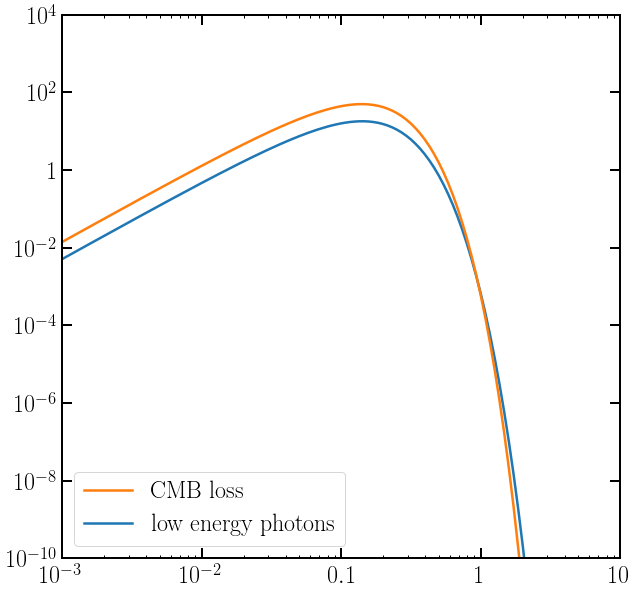

In [34]:
rs_tmp=lowengphot_tflist_arr[0].rs[30]
xe_tmp=xes[0]
eng_i=226

loweng_tf = lowengphot_tf_interp.get_tf(rs_tmp, xe_tmp)
higheng_tf = highengphot_tf_interp.get_tf(rs_tmp, xe_tmp)
loweng_elec_tf = lowengelec_tf_interp.get_tf(rs_tmp, xe_tmp)

eng = loweng_tf.eng

mDM = 2*loweng_tf.in_eng[eng_i]
print(loweng_tf.in_eng[eng_i])
diff = loweng_tf[eng_i].toteng() + higheng_tf[eng_i].toteng() + loweng_elec_tf[eng_i].toteng() - loweng_tf.in_eng[eng_i]
print(diff)

### Unit Norm CMB spectrum ###
T = phys.TCMB(rs_tmp)
def CMB_dNdE_at_T(eng):
    return phys.CMB_spec(eng, T)

dlnz = loweng_tf.dlnz
dt = dlnz/phys.hubble(rs_tmp)  
CMB_spec = spectools.discretize(eng, CMB_dNdE_at_T)
CMB_spec.switch_spec_type()
norm_spec = CMB_spec/CMB_spec.toteng()

### CMB engloss ###
E_CMB_loss = CMB_engloss_arr[0,eng_i,30]*dt
print(E_CMB_loss)

### Normalize ###
test_spec = norm_spec * diff

### Plot ###
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
lowengphot_plt, = plt.plot(loweng_tf[eng_i].eng, loweng_tf[eng_i].N, label='low energy photons')
CMBplt, = plt.plot(eng,test_spec.N, label='CMB loss')
plt.legend(handles=[CMBplt,lowengphot_plt], loc=3)
plt.axis([1e-3, 10, 1e-10, 1e4])
plt.show()

## Injected Electron and Photon Spectra

`in_spec_elec`, `in_spec_phot`:

Each DM decay/annihilation event produces a spectrum of electrons or, in our example, photons.  For a decay event, the spectrum is two photons of energy $m_{DM}/2$ amd for an annihilation event it is two photons at $m_{DM}$.

In [8]:
if inj_type == 'decay':
    phot_spec_init = spectools.rebin_N_arr(
        np.array([2]), # Number of particles in each bin
        np.array([mDM/2]), # Energy of each bin
        highengphot_tf_interp.eng # Desired energy abscissa of phot_spec_init
    )
else:
    phot_spec_init = spectools.rebin_N_arr(
        np.array([2]), 
        np.array([mDM]), 
        highengphot_tf_interp.eng
    )
    
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()

elec_spec_init = 0*phot_spec_init

__Note__: the rs of `in_spec_elec` and `in_spec_phot` will define the rs at which the TLA integration begins.

## main.evolve()

After specifying `end_rs`, we are ready to run main.evolve().

In [9]:
%autoreload
end_rs = 5

std_data = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 
    end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=True
)
#!!!Make it so that xe_init and Tm_init are set to their standard values if they are left blank

# backreact_histories = main.evolve(
#     phot_spec_init*0, phot_spec_init,
#     rate_func__N, rate_func_eng, 
#     end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
#     coarsen_factor=1, std_soln=False
# )

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),
/Users/GregoryRidgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# CMB puzzles -------

In [12]:
#CMBloss
lowengphot_tflist_arr  = pickle.load(open(direc+"tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))

In [11]:
# 0: xe history
# 1: Tm history
# 2, 3, 4: high energy photons, low energy photons, low energy electrons histories
# 5: f_c history
histories = std_data

In [12]:
np.log(64.6699011866251)

4.169295887494215

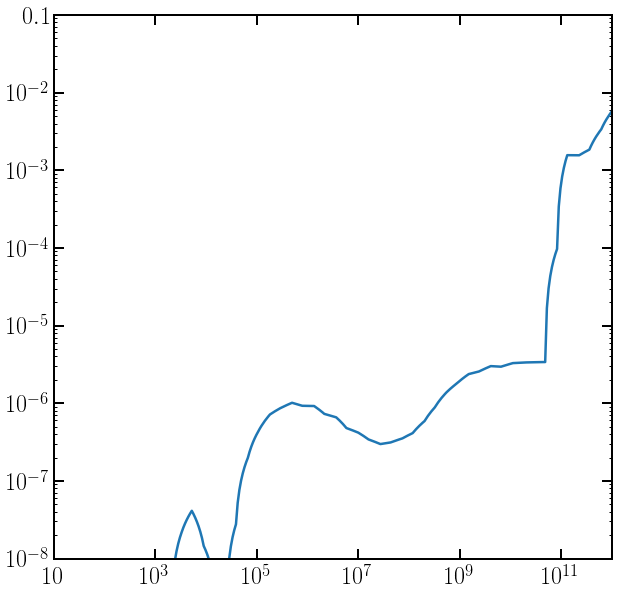

In [13]:
dlnE = .07711605913239428
Einit = 64.6699011866251
x_axis = Einit*np.exp(np.arange(0,dlnE*len(CMB_engloss_arr[10,50,:]),dlnE))

plt.figure()
tmp = plt.plot(x_axis, CMB_engloss_arr[1,10,:])

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.axis([10, 1e12, 1e-8, .1])

plt.show()

In [14]:
print("CMB engloss shape:", CMB_engloss_arr.shape)
print("lowengphot shape:", 
      len(lowengphot_tflist_arr), 
      len(lowengphot_tflist_arr[0].rs),
      len(lowengphot_tflist_arr[0].eng))

CMB engloss shape: (11, 51, 325)
lowengphot shape: 11 51 500


`CMB_engloss_arr` contains the CMB energy loss rate per baryon
$$ \frac1{N_B}\frac{dE}{dt} $$

`phys.CMB_spec` returns the number of CMB photons per $cm^3$ per $eV$, so would seem to be
$$ \frac{dN_\text{CMB}}{dE dV} $$

In [27]:
len()

325

In [29]:
ind = -100

xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

CMB_engloss_copy = CMB_engloss_arr.copy()
for i, k in zip(np.arange(len(xes)), np.arange(len(x_axis))):
    CMB_engloss_copy[i,:,k] = np.flipud(CMB_engloss_arr[i,:,k])

CMB_engloss_interp = RegularGridInterpolator(
    (xes, 
     np.flipud(lowengphot_tflist_arr[0].rs), 
     lowengphot_tflist_arr[0].in_eng),CMB_engloss_arr
)

# Spectra of CMB as a function of rs
eng = std_data[3].eng
rs_list = std_data[3].rs
dlnz = np.log(rs_list[0]) - np.log(rs_list[1])
CMB_spectra = [Spectrum(np.array([]), np.array([])) for rs in rs_list[ind:]]

def CMB_dNdE_at_T(eng):
    return phys.CMB_spec(eng, T)

for i,rs in enumerate(rs_list[ind:]):
    T = phys.TCMB(rs)
    dt = dlnz/phys.hubble(rs)
    
    CMB_spec = spectools.discretize(eng, CMB_dNdE_at_T)
    CMB_spec.switch_spec_type()
    #total CMB energy per volume
    E_CMB = CMB_spec.toteng()
    
    #CMB energy loss per volume
    E_CMB_loss = CMB_engloss_interp(
        [min(std_data[0][i], .999), rs, mDM/2]
    ) * phys.nB*rs**3 * dt
    
    CMB_spec.N = CMB_spec.N * E_CMB_loss/E_CMB
    CMB_spectra[i] = CMB_spec
    CMB_spec.rs = rs
    
CMB_spectra = Spectra(CMB_spectra)

In [21]:
utils.compare_arr([CMB_spectra.eng, std_data[3][0].eng])

[[  1.03884797e-04   1.03884797e-04]
 [  1.12113005e-04   1.12113005e-04]
 [  1.20992928e-04   1.20992928e-04]
 [  1.30576187e-04   1.30576187e-04]
 [  1.40918488e-04   1.40918488e-04]
 [  1.52079953e-04   1.52079953e-04]
 [  1.64125463e-04   1.64125463e-04]
 [  1.77125039e-04   1.77125039e-04]
 [  1.91154248e-04   1.91154248e-04]
 [  2.06294642e-04   2.06294642e-04]
 [  2.22634233e-04   2.22634233e-04]
 [  2.40268003e-04   2.40268003e-04]
 [  2.59298457e-04   2.59298457e-04]
 [  2.79836221e-04   2.79836221e-04]
 [  3.02000681e-04   3.02000681e-04]
 [  3.25920680e-04   3.25920680e-04]
 [  3.51735264e-04   3.51735264e-04]
 [  3.79594496e-04   3.79594496e-04]
 [  4.09660321e-04   4.09660321e-04]
 [  4.42107514e-04   4.42107514e-04]
 [  4.77124690e-04   4.77124690e-04]
 [  5.14915405e-04   5.14915405e-04]
 [  5.55699338e-04   5.55699338e-04]
 [  5.99713568e-04   5.99713568e-04]
 [  6.47213949e-04   6.47213949e-04]
 [  6.98476604e-04   6.98476604e-04]
 [  7.53799523e-04   7.53799523e-04]
 

0

In [24]:
print(std_data[3].spec_type, CMB_spectra.spec_type)

N N


[0.0001, 10000.0, 1e-44, 5000]

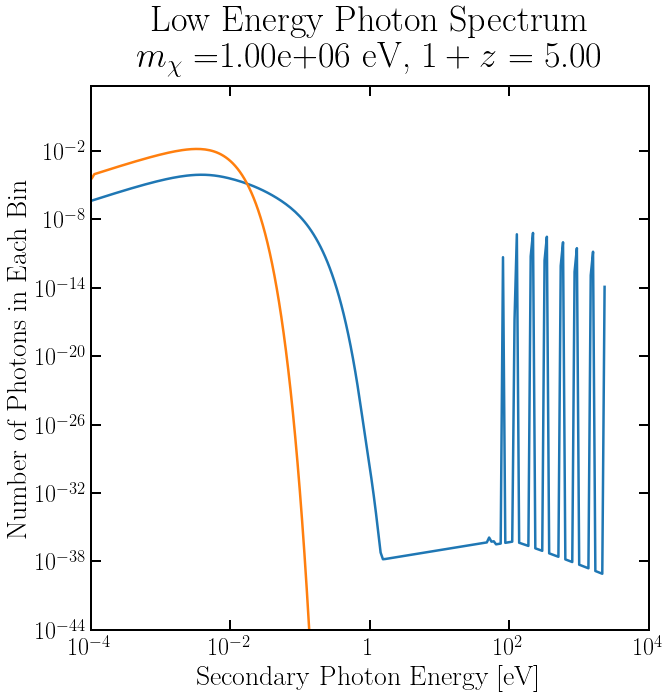

In [19]:
plt.figure()

rs_plot = 5.0

ax = plt.gca()
tf_plot, = std_data[3].plot(ax, ind=rs_plot, fac=1, indtype='rs')
CMB_plot, = CMB_spectra.plot(ax, ind=rs_plot, fac=1e-8, indtype='rs')
# tf_plot, = lowengphot_spectra.plot(ax, ind=20)


ax.set_xscale('log')
ax.set_yscale('log')

plt.title('Low Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mDM)
          +r' eV, $1+z$ = '+'{0:.2f}'.format(rs_plot)
         )

#ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))


plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 1e4, 1e-44, 5000])

# End of CMB puzzles ------

[None, None]

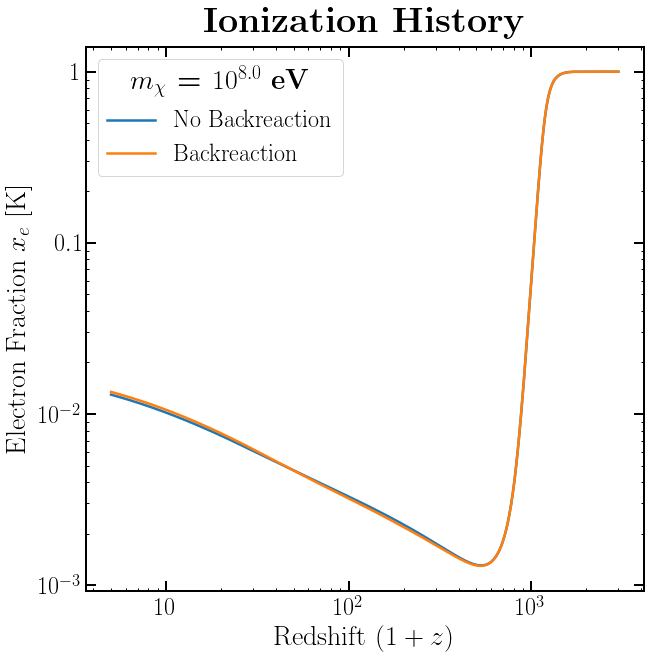

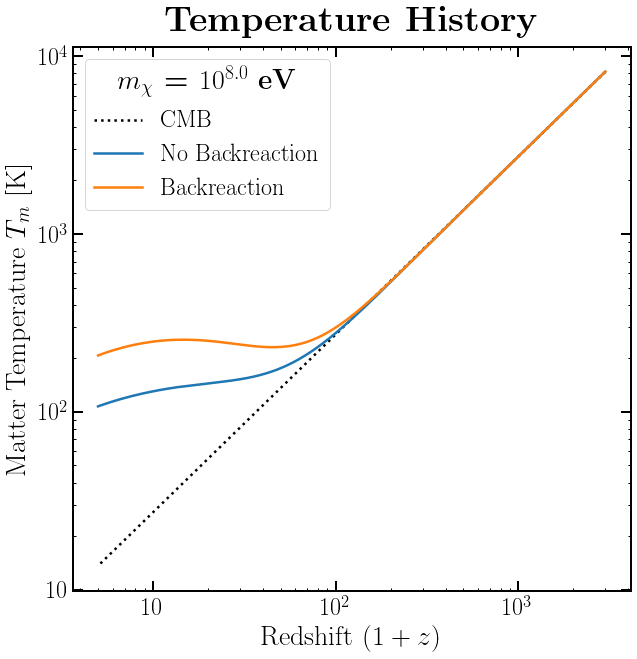

In [17]:
plt.figure()
plt_xe_std, = plt.plot(std_data[3].rs, std_data[0], label='No Backreaction')
plt_xe_backReact, = plt.plot(backreact_data[3].rs, backreact_data[0], label='Backreaction')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_xe_std, plt_xe_backReact],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)

plt.figure()
plt_TCMB, = plt.plot(std_data[3].rs, phys.TCMB(std_data[3].rs)/phys.kB, 'k:', label='CMB')
plt_Tm_std, = plt.plot(std_data[3].rs, std_data[1]/phys.kB, label='No Backreaction')
plt_Tm_backReact, = plt.plot(backreact_data[3].rs, backreact_data[1]/phys.kB, label='Backreaction')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_TCMB, plt_Tm_std, plt_Tm_backReact],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=2
                 )
plt.setp(leg2.get_title(),fontsize=28)

[None, None]

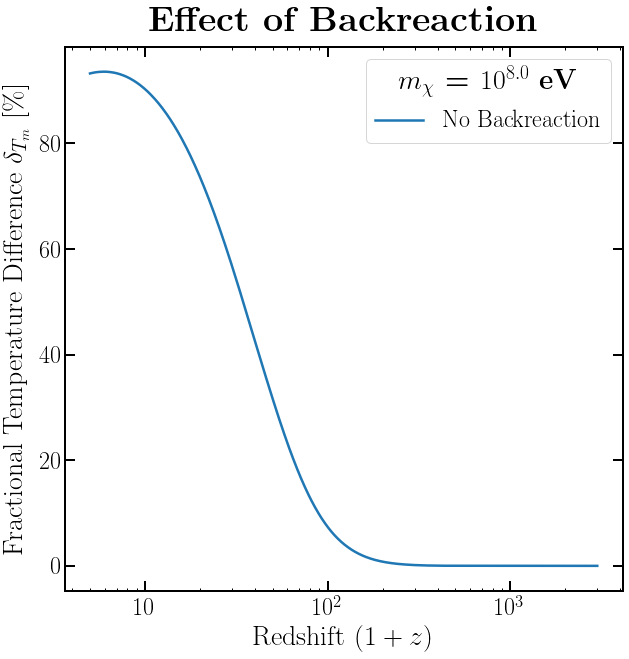

In [18]:
plt.figure()
plt_Tm_diff, = plt.plot(
    std_data[3].rs, np.abs((std_data[1]-backreact_data[1])/std_data[1] * 100), 
    label='No Backreaction'
)

ax = plt.gca()
ax.set_xscale('log')
#ax.set_yscale('log')

plt.title(r'\bf{Effect of Backreaction}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Fractional Temperature Difference $\delta_{T_m}$ [\%]')
leg2 = plt.legend(handles=[plt_Tm_diff],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=1
                 )
plt.setp(leg2.get_title(),fontsize=28)

# Scratch Work

In [154]:
# p-wave structure formation
NFW_subs_data = []
with open('/home/gridgway/Dropbox (MIT)/21cm_pwave/math/data/rho_eff_NFW_subs_pwave.txt') as f:
    for line in f:
        inner_list = [float(num.strip()) for num in line.split(' ') if num]
        NFW_subs_data.append(inner_list)
        
NFW_subs_data = np.array(NFW_subs_data)
NFW_subs_data[:,2] *= .839418
NFW_subs_data[:,0] += 1
sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
NFW_subs_data[:,1] = phys.rho_DM * NFW_subs_data[:,0]**4 * 10**-9 * sigma_1D_B/phys.c

struct_boost_raw = (NFW_subs_data[:,2]/NFW_subs_data[:,1])**2

log10_struct_boost = interp1d(NFW_subs_data[:,0], np.log10(struct_boost_raw))

def struct_boost(rs):
    if rs < NFW_subs_data[-1,0]:
        return 10**log10_struct_boost(rs)
    else:
        return 1.

- RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded

- why are there fewer energy bins in CMB_engloss_arr than the tflists?

-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?
 - just from PLANCK bounds you'll know that 1 out of 10^9 DM particles have decayed/annihilated

-Why don't we go above 5 TeV?
 - other processes above 10 TeV (triplet pair productions)
 
-injection of entropy
 - think difference in photon temperature and $\nu$ temp due to electron positron annihilation
 
-Unitarity constraint
 - point-like DM that gets its abundance through annihilation 
 - prob of scattering can't be more than one, a limit on _annihilation_ rate
 - Impossible to get to that $10^{-26}$ cross-section

-Why are the lowengphot spectra so spiky?

TODO:
    - incorporate reionization into main.evolve()
    - figure out CMB loss puzzles
    - write draft
    - Check against Hongwan's 2016 paper's back-reaction calculation
    - think of other means of independent verification

DONE:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation


- Structure Formation
    - swave
    - on/off switch
    - optimistic/conservative
    - (just a change to the annihilation rate)
    
- minimum lifetime (do this first, structure independent)/maximum cross-section
    - residual plot of with back-reaction vs. not back-react (temperature), contour plots
    - for each mass pick the minimum tau or maximum cross-section and compare the std_switch on or off
    
- New 21cm sensitivity
    - Hongwan's plots, but now with DarkHistory